In [97]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import simpson

from simulate_helpers import invt_sample_z
from model_helpers import ln_normal, ln_two_sech2
from integrate_helpers import log_simpson

# The analytic way

See the `Orthogonal-basis.nb` mathematica notebook.

Term 0:
$$
\begin{align}
f_0(z) &= a_{00}\\
\int \textrm{d}z \, f_0(z)^2 \, \rho(z) &= 1\\
\int \textrm{d}z \, a_{00}^2 \, \rho(z) &= 1\\
\end{align}
$$
so $a_{00}=1$

---

Term 1:
$$
\begin{align}
f_1(z) &= a_{10} + a_{11} \, z\\
\int \textrm{d}z \, f_1(z)^2 \, \rho(z) &= 1\\
\int \textrm{d}z \, f_0(z) \, f_1(z) \, \rho(z) &= 0\\
\end{align}
$$

Mathematica says: 
$$
\begin{align}
a_{10} &= 0\\
a_{11} &= \frac{\sqrt{3}}{\pi} \, \left( h_2^2 + f\, (h_1 - h_2)\,(h_1 + h_2) \right)^{-1/2}
\end{align}
$$

---

Term 2:
$$
\begin{align}
f_2(z) &= a_{20} + a_{21} \, z + a_{22} \, z^2\\
\int \textrm{d}z \, f_2(z)^2 \, \rho(z) &= 1\\
\int \textrm{d}z \, f_0(z) \, f_2(z) \, \rho(z) &= 0\\
\int \textrm{d}z \, f_1(z) \, f_2(z) \, \rho(z) &= 0\\
\end{align}
$$

Mathematica says:
$$
\begin{align}
a_{20} &= \frac{1}{3}(-22\,f\,h_1^2\,\pi^2 - 22\,h_2^2\,\pi^2 + 22\,f\,h_2^2\,\pi^2)\\
a_{21} &= 0\\
a_{22} &= \textrm{huge expression}
\end{align}
$$

In [76]:
pars = {
    'h1': 120, 
    'h2': 400, 
    'f': 0.75
}

In [77]:
def ln_density(z, **kw):
    return ln_two_sech2(z, **kw)

In [87]:
def f1(z, h1, h2, f):
    return np.sqrt(3) / np.pi * (h2**2 + f*(h1-h2)*(h1+h2))**-0.5 * z

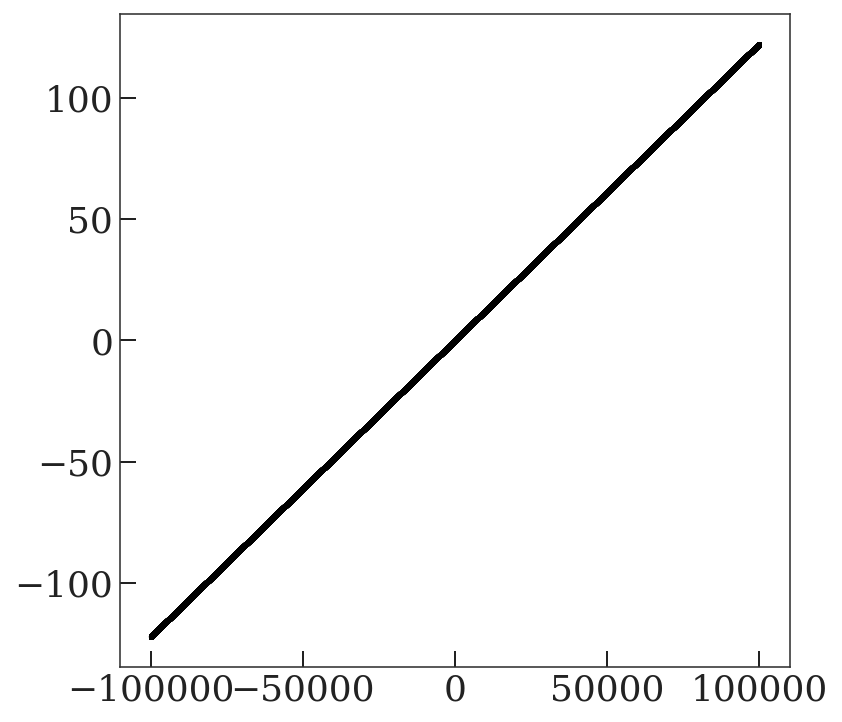

In [115]:
alpha = 0.5
zgrid = np.arange(-100, 100, 1e-3) * 1e3
ln_dens0 = ln_density(zgrid, **pars)
dens1 = f1(zgrid, **pars)
dens = alpha * np.exp(ln_dens0) + (1-alpha) * (dens1)

plt.plot(zgrid, dens)

In [126]:
zgrid = np.linspace(-1000, 1000, 1024)
simpson(f1(zgrid, **pars), x=zgrid)

0.0

In [121]:
from scipy.integrate import quad

In [123]:
quad(lambda z: f1(z, **pars), -100, 100)

(0.0, 2.705621306299946e-13)

---

# The numerical way

Pre-compute integrals:

In [144]:
zgrid = np.arange(0, 100, 1e-3)[1:]  # kpc
ln_dens_fiducial = ln_two_sech2(zgrid * 1e3, **pars)

log_simpson(ln_dens_fiducial + np.log(zgrid), x=zgrid)

-8.935005931695493

In [145]:
log_simpson(ln_dens_fiducial + 2 * np.log(zgrid), x=zgrid)

-9.389913907765116

In [146]:
log_simpson(ln_dens_fiducial + 3 * np.log(zgrid), x=zgrid)

-9.276923724904862

In [154]:
for power in [0, 1, 2, 3, 4]:
    val, err = quad(lambda z: np.exp(2*np.log(z) + ln_two_sech2(z, **pars)), 0, np.inf)
    print(log_simpson(ln_dens_fiducial + power * np.log(zgrid), x=zgrid))

-7.60434586300986
-8.935005931695493
-9.389913907765116
-9.276923724904862
-8.811570804347541


In [156]:
for power in [0, 1, 2, 3, 4]:
    val, err = quad(lambda z: np.exp(power * np.log(z) + ln_two_sech2(z, **pars)), 0, np.inf)
    print(np.log(val / 1e3**(power + 1)))

-7.600902459542079
-8.934999406385453
-9.389913900909093
-9.276923724899657
-8.811570804347538


In [177]:
class FuncWrapper:
    
    def __init__(self, func):
        self.func = func
        
    def __mul__(self, rhs):
        return FuncWrapper(lambda *args: rhs * self.func(*args))
    
    def __truediv__(self, rhs):
        return FuncWrapper(lambda *args: self.func(*args) / rhs)
    
    def __add__(self, rhs):
        return FuncWrapper(lambda *args: rhs + self.func(*args))
    
    def __sub__(self, rhs):
        return FuncWrapper(lambda *args: self.func(*args) - rhs)
    
    def __call__(self, *args):
        return self.func(*args)

In [184]:
# test_wrap = FuncWrapper(np.polynomial.Polynomial())
# shit = test_wrap / 5 + 1
# shit(2)

In [289]:
import copy

def gram_shit(objs, inner_product_func, args=()):
    """
    Parameters
    ----------
    objs : iterable of callables, arrays, etc.
    inner_product_func : callable
        Must take at minimum two arguments and return a scalar.
        This could optionally take a third argument, such as a 
        measure function and grid of values, ...
    args : iterable
    
    Returns
    -------
    basis_objs : list
        A list of orthonormal objects (functions, vectors, etc.).
    """
    basis_objs = []
    for obj in objs:
        this_bob = copy.copy(obj)
        for bobj in basis_objs:
            this_bob = this_bob - inner_product_func(this_bob, bobj, *args) * bobj
        print(inner_product_func(this_bob, this_bob, *args))
        this_bob = this_bob / np.sqrt(inner_product_func(this_bob, this_bob, *args))
        basis_objs.append(this_bob)
    return basis_objs

In [229]:
def test_vector_ip(obj1, obj2):
    return np.dot(obj1, obj2)

In [234]:
vecs = np.array([
    [1.4, 6.1, 3.3],
    [4.2, 3.3, 0.5],
    [11.3, 5, 3.]
])
basis_vecs = gram_shit(vecs, test_vector_ip)

for i, vec1 in enumerate(basis_vecs):
    for j, vec2 in enumerate(basis_vecs):
        assert np.isclose(vec1 @ vec2, int(i == j))

In [251]:
def test_legendre_ip(f1, f2):
    grid = np.linspace(-1, 1, 1025)  # BOO YA
    return simpson(f1(grid) * f2(grid) / 2, x=grid)

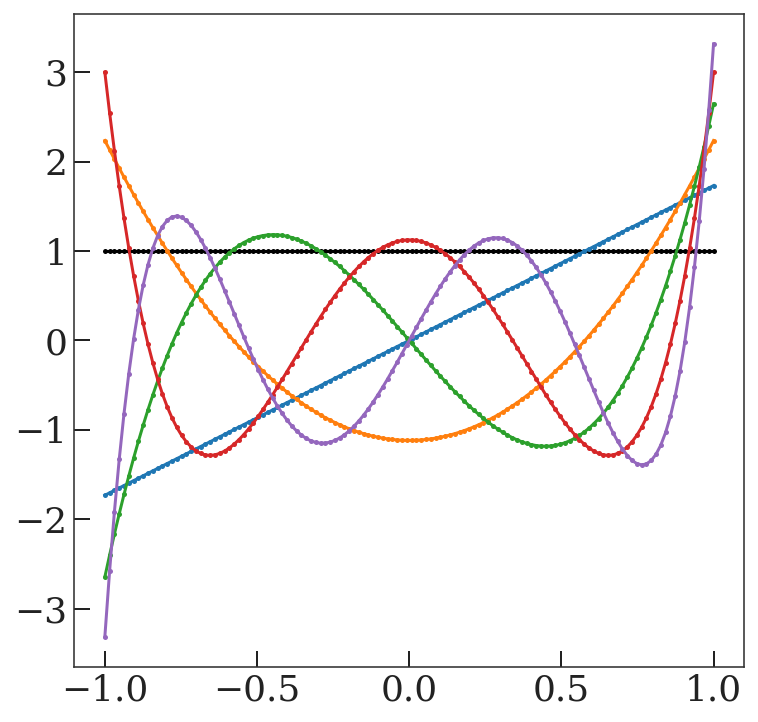

In [253]:
funcs = [np.polynomial.Polynomial.basis(deg) for deg in range(6)]
basis_funcs = gram_shit(funcs, test_legendre_ip)

grid = np.linspace(-1, 1, 128)
for func in basis_funcs:
    plt.plot(grid, func(grid))

2.5066282746310002
2.5066282746310007
5.013256549262001
15.039769647786002
60.15907859114401
300.79539295571976
1804.7723577342888


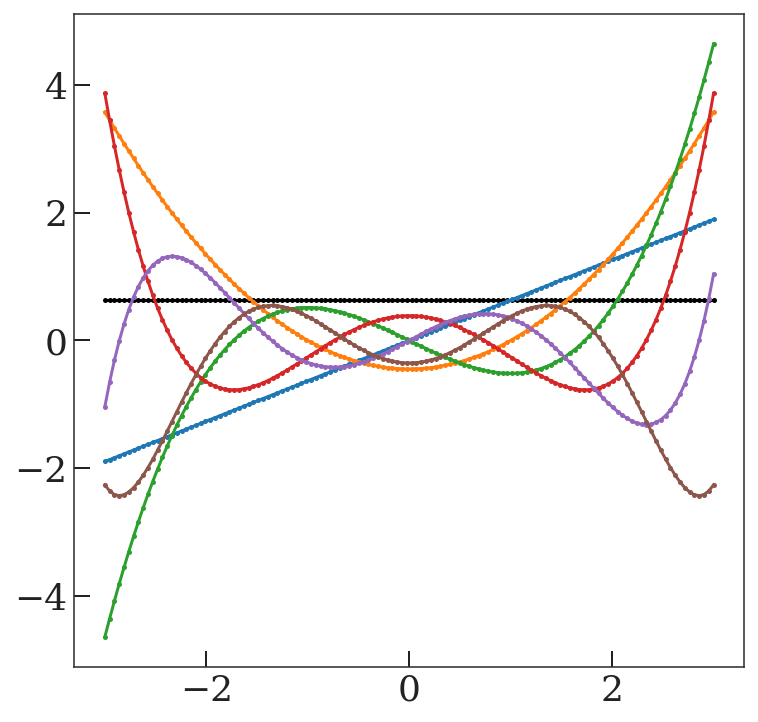

In [370]:
def test_hermite_ip(f1, f2):
    grid = np.linspace(-10, 10, 1025)  # BOO YA
    return simpson(f1(grid) * f2(grid) * np.exp(-grid**2 / 2), x=grid)

funcs = [np.polynomial.Polynomial.basis(deg) for deg in range(7)]
basis_funcs = gram_shit(funcs, test_hermite_ip)

grid = np.linspace(-3, 3, 128)
for func in basis_funcs:
    plt.plot(grid, func(grid))

In [291]:
from scipy.integrate import trapezoid

In [371]:
def test_func_ip(f1, f2, measure_func, grid, scale):
    # TODO: or use quad() with the function handle
    return simpson(f1(grid) * f2(grid) * measure_func(scale * grid) * scale,
                   x=grid)
#     return trapezoid(f1(grid) * f2(grid) * measure_func(grid),
#                      x=grid)


def test_func_ip_quad(f1, f2, measure_func, scale):
    return quad(lambda z: f1(z) * f2(z) * measure_func(scale * z) * scale, -np.inf, np.inf)[0]

In [376]:
funcs = [np.polynomial.Polynomial.basis(deg) for deg in range(15)]

measure_func = lambda z: np.exp(ln_two_sech2(z, **pars))
grid = np.arctanh(np.linspace(-1+1e-8, 1-1e-8, 8192))

# sech2_basis_funcs = gram_shit(funcs, test_func_ip, args=(measure_func, grid, pars['h2']))
sech2_basis_funcs = gram_shit(funcs, test_func_ip_quad, args=(measure_func, pars['h2']))

/mnt/ceph/users/apricewhelan/projects/solar-velocity/notebooks/model_helpers.py:16: RuntimeWarning: overflow encountered in cosh
  lnterm1 = np.log(f) - 2 * np.log(np.cosh(z / (2 * h1))) - np.log(4 * h1)
/mnt/ceph/users/apricewhelan/projects/solar-velocity/notebooks/model_helpers.py:17: RuntimeWarning: overflow encountered in cosh
  lnterm2 = np.log(1 - f) - 2 * np.log(np.cosh(z / (2 * h2))) - np.log(4 * h2)


1.0
1.044533132448624
10.549499262265414
225.84903628216955
8773.386430928573
540309.2660407217
47311969.01311639
5741412329.334152
896581239823.2539
179986408161962.84
4.402320246428605e+16
1.3198164762653745e+19
4.656754882203203e+21
1.9489931586857795e+24
9.372100336383418e+26


In [377]:
sech2_basis_funcs[8]

Polynomial([ 1.76496730e-01,  0.00000000e+00, -3.58835559e-01,  0.00000000e+00,
        2.62440636e-02,  0.00000000e+00, -3.61081615e-04,  0.00000000e+00,
        1.05610033e-06], domain=[-1.,  1.], window=[-1.,  1.])

In [378]:
# plt.plot(grid, measure_func(grid))

(-5.0, 5.0)

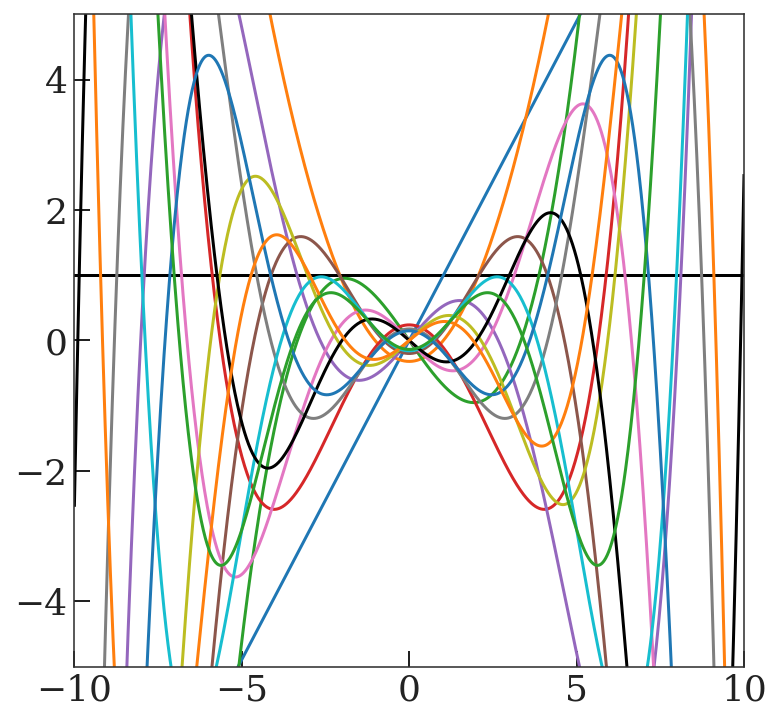

In [379]:
plot_grid = np.linspace(-10, 10, 1024)
for func in sech2_basis_funcs:
    plt.plot(plot_grid, func(plot_grid), marker='')
# plt.xlim(-5000, 5000)
plt.xlim(-10, 10)
plt.ylim(-5, 5)

Text(0.5, 0, '$z$ [kpc]')

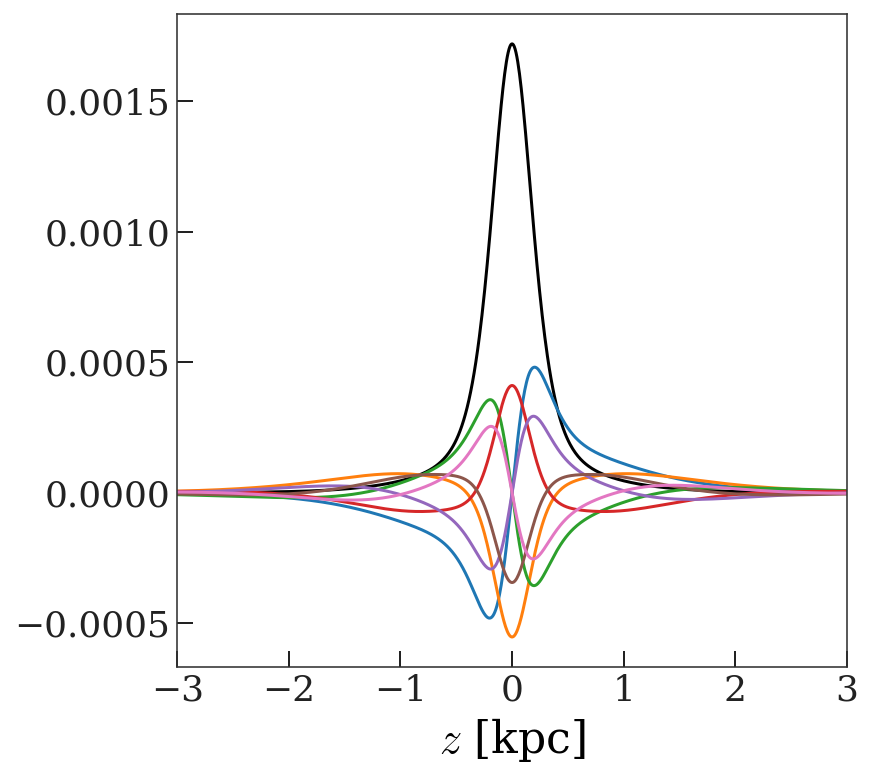

In [388]:
plot_grid = np.linspace(-10, 10, 1024)
for func in sech2_basis_funcs[:8]:
    plt.plot(
        plot_grid * pars['h2'] / 1e3, 
        func(plot_grid) * measure_func(plot_grid * pars['h2']), 
        marker=''
    )
# plt.xlim(-5000, 5000)
plt.xlim(-3, 3)
plt.xlabel('$z$ [kpc]')

In [75]:
def ln_schmdot(coeffs1, coeffs2, ln_density):
    zgrid = np.linspace(-10, 10, 1024)
    gi = np.poly1d(coeffs1)(zgrid)
    fj = np.poly1d(coeffs2)(zgrid)
    
    logdens = np.log(gi(zgrid)) + np.log(fj(zgrid)) + ln_density(zgrid)
    return log_simpson(logdens, x=zgrid)